In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

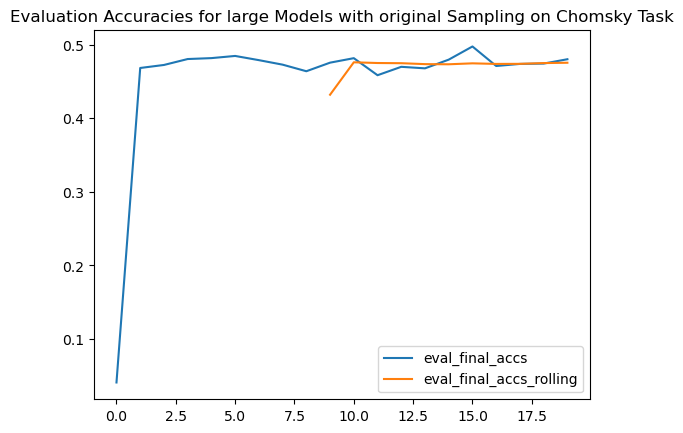

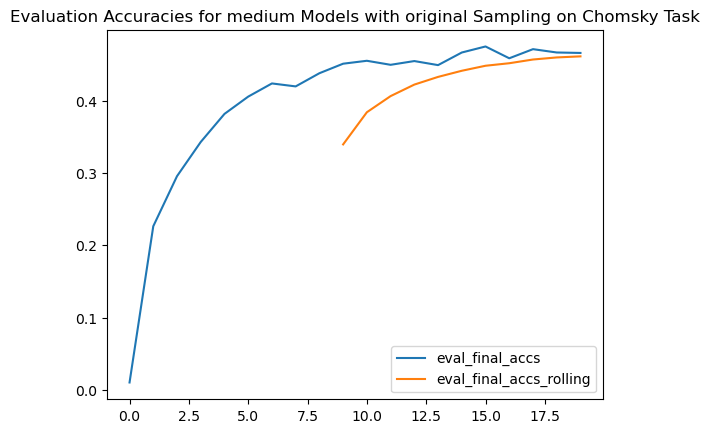

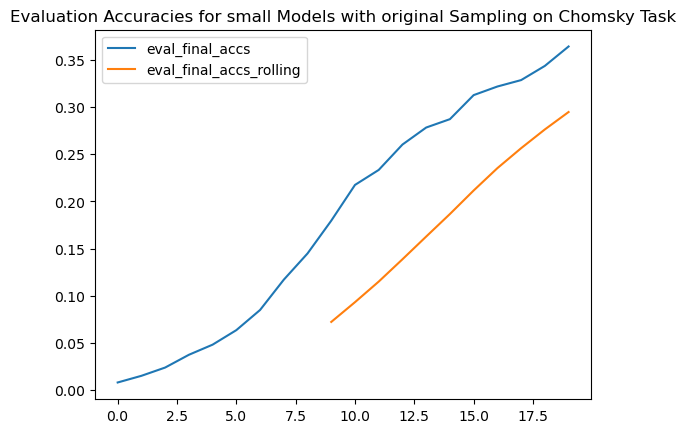

In [8]:
# Generate Eval Accuracies Graph
use_markovs = [
    # True, 
    False
]

model_sizes = [
    "large", 
    "medium", 
    "small"
]

for use_markov in use_markovs:
    suffix = "markov" if use_markov else "original"
    for model_size in model_sizes:
        results = pd.read_csv(f'artifacts/metrics_{suffix}_transformer_{model_size}.csv')
        eval_accs = results['eval_accs']
        eval_final_accs = results['eval_final_accs']
        # plt.plot(eval_accs, label='eval_accs')
        plt.plot(eval_final_accs, label='eval_final_accs')
        eval_accs_rolling = pd.Series(eval_accs).rolling(window=10).mean()
        eval_final_accs_rolling = pd.Series(eval_final_accs).rolling(window=10).mean()
        # plt.plot(eval_accs_rolling, label='eval_accs_rolling')
        plt.plot(eval_final_accs_rolling, label='eval_final_accs_rolling')
        plt.legend()
        plt.title(f'Evaluation Accuracies for {model_size} Models with {suffix} Sampling on Chomsky Task')
        plt.show()

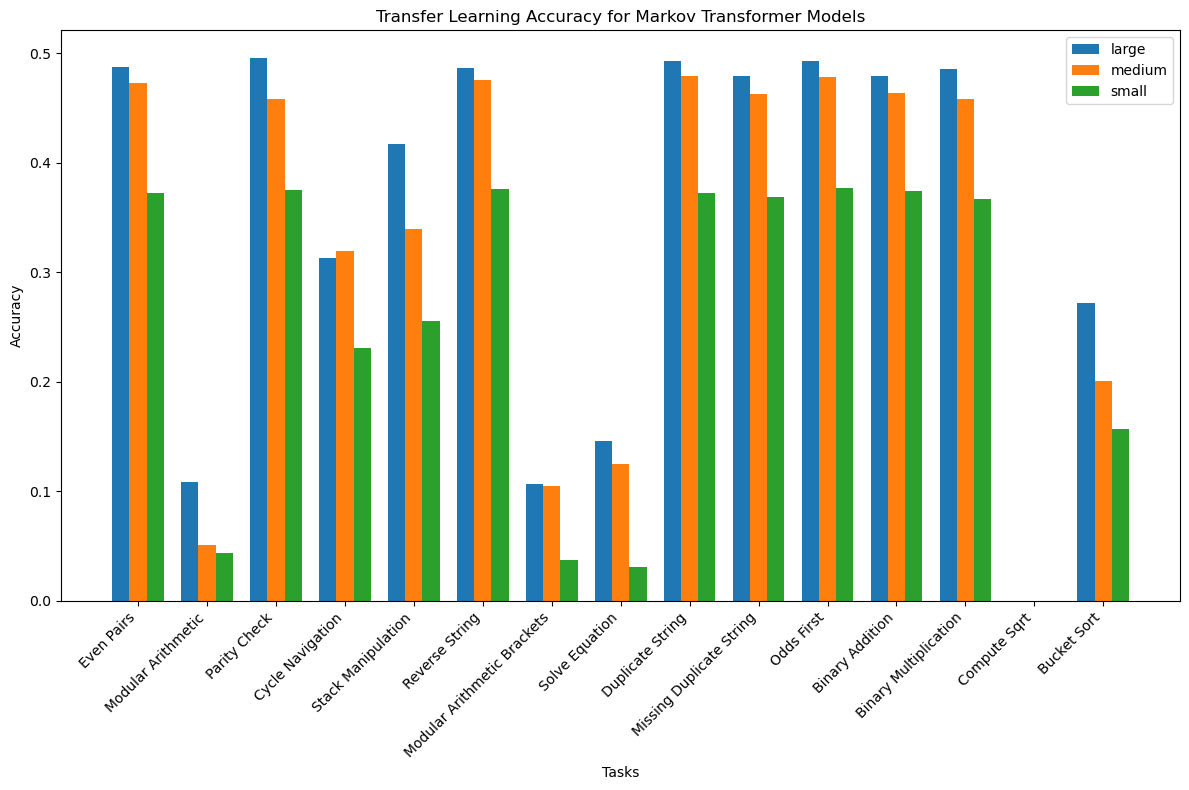

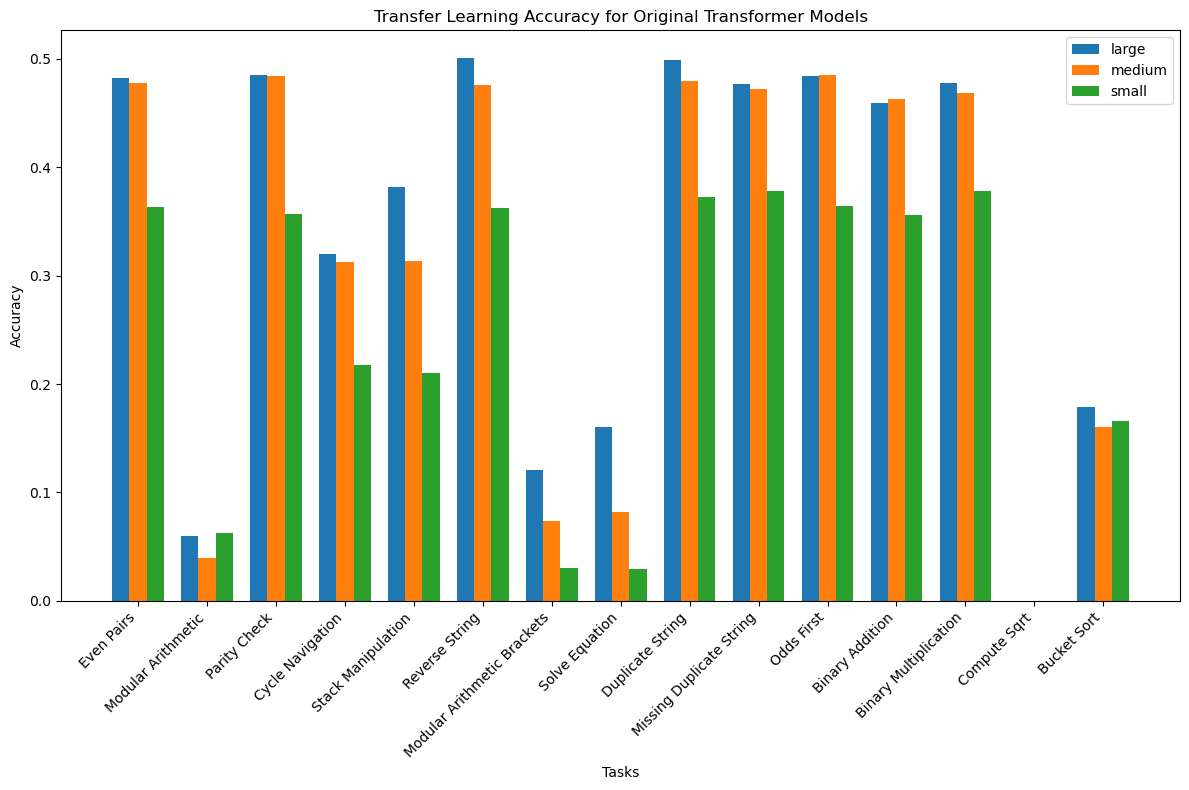

In [10]:
# Generate Plot for Transfer Learning Accuracies
# For each model sizes, small, medium, large, plot the transfer learning accuracy of the model for each Chomsky task
# For each model type (Markov or Original), plot the transfer learning accuracy of the model for each Chomsky task

# Load the Chomsky results
with open('artifacts/chomsky_results.json', 'r') as f:
    chomsky_results = json.load(f)

model_types = [
    "markov", 
    "original"
]

model_sizes = [
    "large", 
    "medium", 
    "small"
]

tasks = [
    # Regular.
    "even_pairs",
    "modular_arithmetic",
    "parity_check",
    "cycle_navigation",
    # Context free.
    "stack_manipulation",
    "reverse_string",
    "modular_arithmetic_brackets",
    "solve_equation",
    # Context sensitive.
    "duplicate_string",
    "missing_duplicate_string",
    "odds_first",
    "binary_addition",
    "binary_multiplication",
    "compute_sqrt",
    "bucket_sort",
]

# Create a figure for each model type
for model_type in model_types:
    plt.figure(figsize=(12, 8))
    
    accuracies = []
    for model_size in model_sizes:
        model_key = f"artifacts/params_{model_type}_transformer_{model_size}.npz"
        if model_key in chomsky_results:
            model_accuracies = []
            for task in tasks:
                if task in chomsky_results[model_key]:
                    model_accuracies.append(chomsky_results[model_key][task]["total_accuracy"])
                else:
                    model_accuracies.append(0)  # Handle missing tasks
            accuracies.append(model_accuracies)
    
    # Plot the data
    x = np.arange(len(tasks))
    width = 0.25
    
    for i, model_size in enumerate(model_sizes):
        plt.bar(x + i*width, accuracies[i] if i < len(accuracies) else [0]*len(tasks), 
                width, label=f'{model_size}')
    
    plt.xlabel('Tasks')
    plt.ylabel('Accuracy')
    plt.title(f'Transfer Learning Accuracy for {model_type.capitalize()} Transformer Models')
    plt.xticks(x + width, [task.replace('_', ' ').title() for task in tasks], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()
